# Lista 5 - Zespoły klasyfikatorów

Import bibliotek

In [78]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
import optuna
from optuna.integration import CatBoostPruningCallback
import warnings
import catboost as cb
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
np.random.seed(42)

# Jaki zbiór danych będziemy analizować?

## Spaceship Titanic
Zbiór danych zawiera informacje o pasażerach statku Titanic. 
- zbiór pochodzi z konkursu na platformie Kaggle i jest naturalnym następstwem zbioru Titanic.
### treść zadania
Witamy w roku 2912, w którym umiejętności w zakresie nauki o danych są niezbędne do rozwiązania kosmicznej tajemnicy. Otrzymaliśmy transmisję z odległości czterech lat świetlnych i sprawy nie wyglądają dobrze.

Statek kosmiczny Titanic był międzygwiezdnym liniowcem pasażerskim wystrzelonym miesiąc temu. Z prawie 13 000 pasażerów na pokładzie, statek wyruszył w swoją dziewiczą podróż, transportując emigrantów z naszego Układu Słonecznego do trzech nowo nadających się do zamieszkania egzoplanet krążących wokół pobliskich gwiazd.

Podczas okrążania Alfa Centauri w drodze do pierwszego celu podróży - gorącego 55 Cancri E - nieostrożny statek kosmiczny Titanic zderzył się z anomalią czasoprzestrzenną ukrytą w chmurze pyłu. Niestety, spotkał go podobny los jak jego imiennika 1000 lat wcześniej. Chociaż statek pozostał nienaruszony, prawie połowa pasażerów została przetransportowana do innego wymiaru!


### Zadanie
- Klasyfikacja "Transported" - pasażerowie, którzy zostali przetransportowani do innego wymiaru.

# EDA

In [2]:
train_data = pd.read_csv("./spaceship-titanic/train.csv")
display(train_data.head(20))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [3]:
display(train_data.describe())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Możemy zauważyć, że kolumna "Cabin" jest nieznormalizowana: zawiera, Pokład/Number/Stronę. Możemy rozdzielić te informacje na trzy kolumny: Deck, CabinNumber, Side.

In [5]:
train_data[["Deck", "Cabin_num", "Side"]] = train_data["Cabin"].str.split(
    "/", expand=True
)
train_data["Cabin_num"] = pd.to_numeric(train_data["Cabin_num"], errors="coerce")

In [6]:
try:
    train_data = train_data.drop("Cabin", axis=1)
except KeyError:
    print("Field does not exist")

Dla naszego modelu imię i id pasażera nie są istotne, więc możemy je usunąć.

In [7]:
train_data = train_data.drop(["PassengerId", "Name"], axis=1)

In [8]:
display(train_data)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98.0,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499.0,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500.0,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608.0,S


In [9]:
train_data["CryoSleep"] = train_data["CryoSleep"].astype(bool)
train_data["VIP"] = train_data["VIP"].astype(bool)

categorical_columns = ["HomePlanet", "Destination", "Deck", "Side"]
for col in categorical_columns:
    train_data[col] = train_data[col].astype("category")

In [10]:
train_data_before_missing = train_data.copy()

## Wypełnienie brakujących wartości (zależnie od modelu)

In [11]:
for column in train_data.columns:
    train_data[column + "_is_null"] = train_data[column].isnull().astype(int)

categorical_columns = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
numerical_columns = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]

for column in categorical_columns:
    train_data[column].fillna(train_data[column].mode()[0], inplace=True)

for column in numerical_columns:
    train_data[column].fillna(train_data[column].median(), inplace=True)

C:\Users\filip\AppData\Local\Temp\ipykernel_7756\1692797710.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[column].fillna(train_data[column].mode()[0], inplace=True)
C:\Users\filip\AppData\Local\Temp\ipykernel_7756\1692797710.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [12]:
train_data.isnull().sum()

HomePlanet                0
CryoSleep                 0
Destination               0
Age                       0
VIP                       0
RoomService               0
FoodCourt                 0
ShoppingMall              0
Spa                       0
VRDeck                    0
Transported               0
Deck                    199
Cabin_num               199
Side                    199
HomePlanet_is_null        0
CryoSleep_is_null         0
Destination_is_null       0
Age_is_null               0
VIP_is_null               0
RoomService_is_null       0
FoodCourt_is_null         0
ShoppingMall_is_null      0
Spa_is_null               0
VRDeck_is_null            0
Transported_is_null       0
Deck_is_null              0
Cabin_num_is_null         0
Side_is_null              0
dtype: int64

In [13]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,HomePlanet_is_null,CryoSleep_is_null,Destination_is_null,...,VIP_is_null,RoomService_is_null,FoodCourt_is_null,ShoppingMall_is_null,Spa_is_null,VRDeck_is_null,Transported_is_null,Deck_is_null,Cabin_num_is_null,Side_is_null
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8494.000000,8693.000000,8693.0,8693.000000,...,8693.0,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.0,8693.000000,8693.000000,8693.000000
mean,28.790291,220.009318,448.434027,169.572300,304.588865,298.261820,600.367671,0.023122,0.0,0.020936,...,0.0,0.020821,0.021051,0.023927,0.021051,0.021627,0.0,0.022892,0.022892,0.022892
std,14.341404,660.519050,1595.790627,598.007164,1125.562559,1134.126417,511.867226,0.150300,0.0,0.143180,...,0.0,0.142794,0.143564,0.152832,0.143564,0.145469,0.0,0.149568,0.149568,0.149568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000,999.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000,1.000000,0.0,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   HomePlanet            8693 non-null   category
 1   CryoSleep             8693 non-null   bool    
 2   Destination           8693 non-null   category
 3   Age                   8693 non-null   float64 
 4   VIP                   8693 non-null   bool    
 5   RoomService           8693 non-null   float64 
 6   FoodCourt             8693 non-null   float64 
 7   ShoppingMall          8693 non-null   float64 
 8   Spa                   8693 non-null   float64 
 9   VRDeck                8693 non-null   float64 
 10  Transported           8693 non-null   bool    
 11  Deck                  8494 non-null   category
 12  Cabin_num             8494 non-null   float64 
 13  Side                  8494 non-null   category
 14  HomePlanet_is_null    8693 non-null   int32   
 15  Cryo

Zbalansowanie klas

<Axes: xlabel='Transported'>

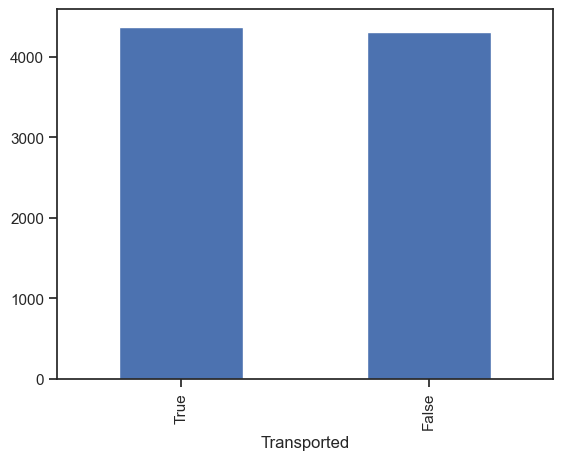

In [77]:
plot_df = train_data.Transported.value_counts()
plot_df.plot(kind="bar")

<Axes: xlabel='Cabin_num', ylabel='Count'>

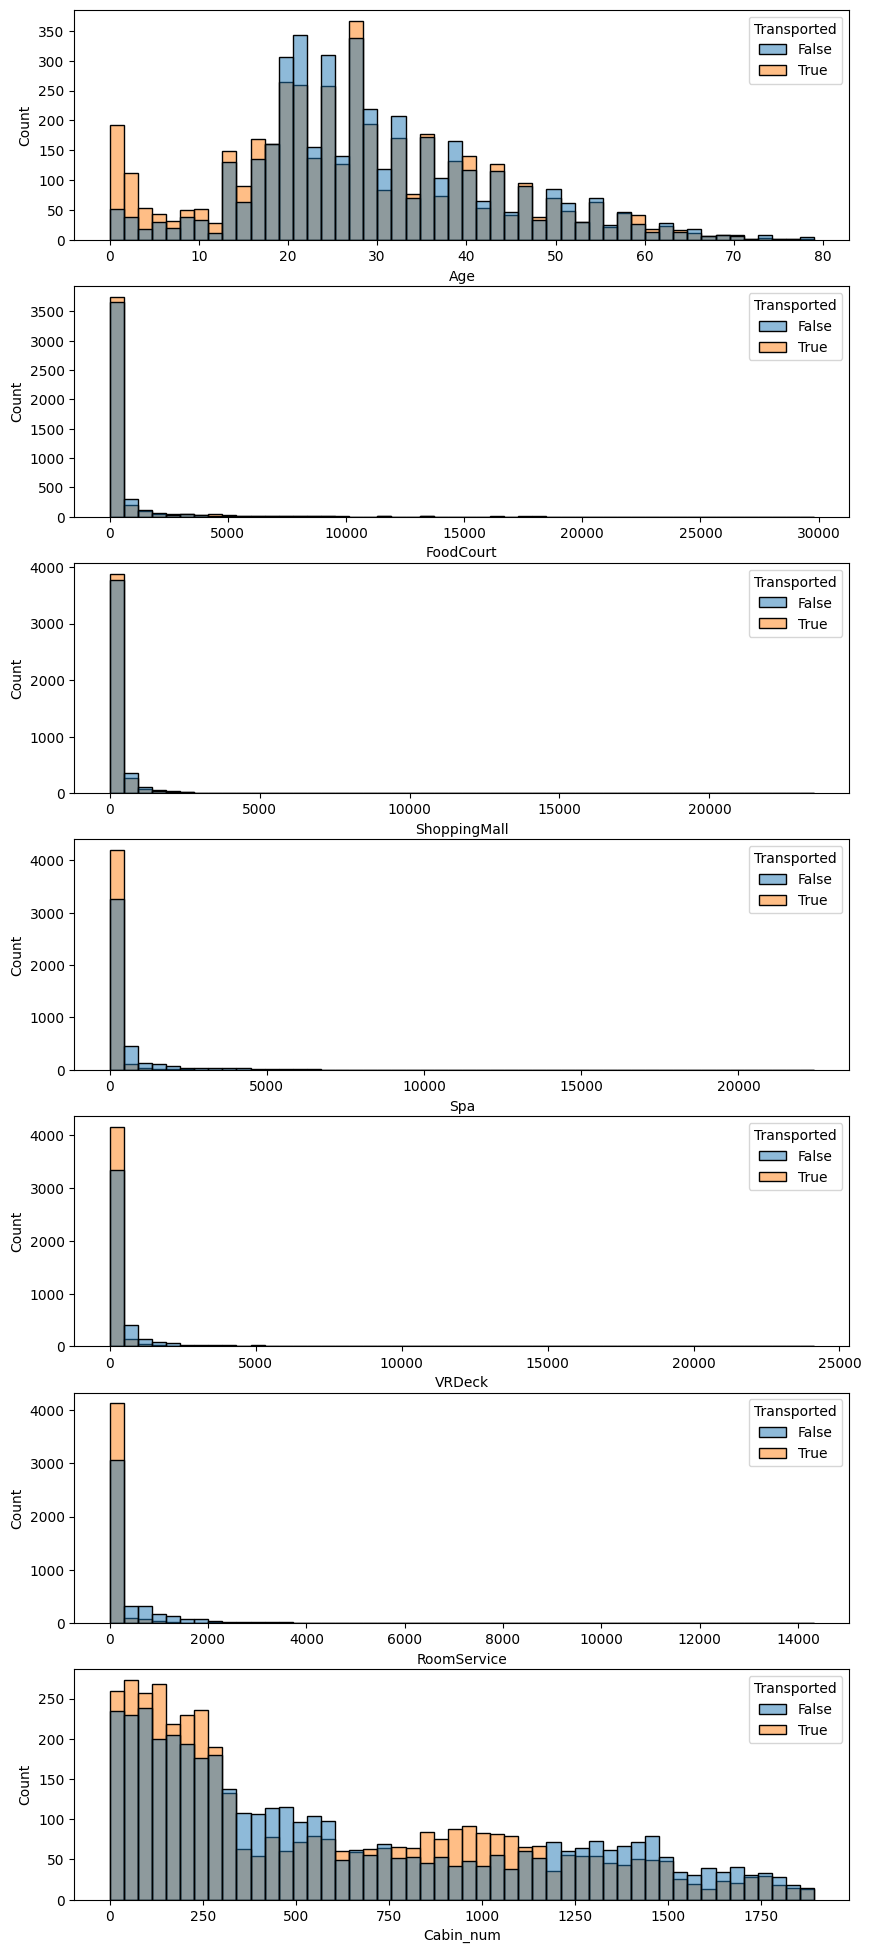

In [16]:
fig, ax = plt.subplots(7, 1, figsize=(10, 10))
plt.subplots_adjust(top=2)

sns.histplot(data=train_data, x="Age",  bins=50, ax=ax[0], hue="Transported")
sns.histplot(data=train_data, x="FoodCourt", bins=50, ax=ax[1], hue="Transported")
sns.histplot(data=train_data, x="ShoppingMall", bins=50, ax=ax[2], hue="Transported")
sns.histplot(data=train_data, x="Spa", bins=50, ax=ax[3], hue="Transported")
sns.histplot(data=train_data, x="VRDeck", bins=50, ax=ax[4], hue="Transported")
sns.histplot(data=train_data, x="RoomService", bins=50, ax=ax[5], hue="Transported")
sns.histplot(data=train_data, x="Cabin_num", bins=50, ax=ax[6], hue="Transported")

<Axes: xlabel='CryoSleep', ylabel='count'>

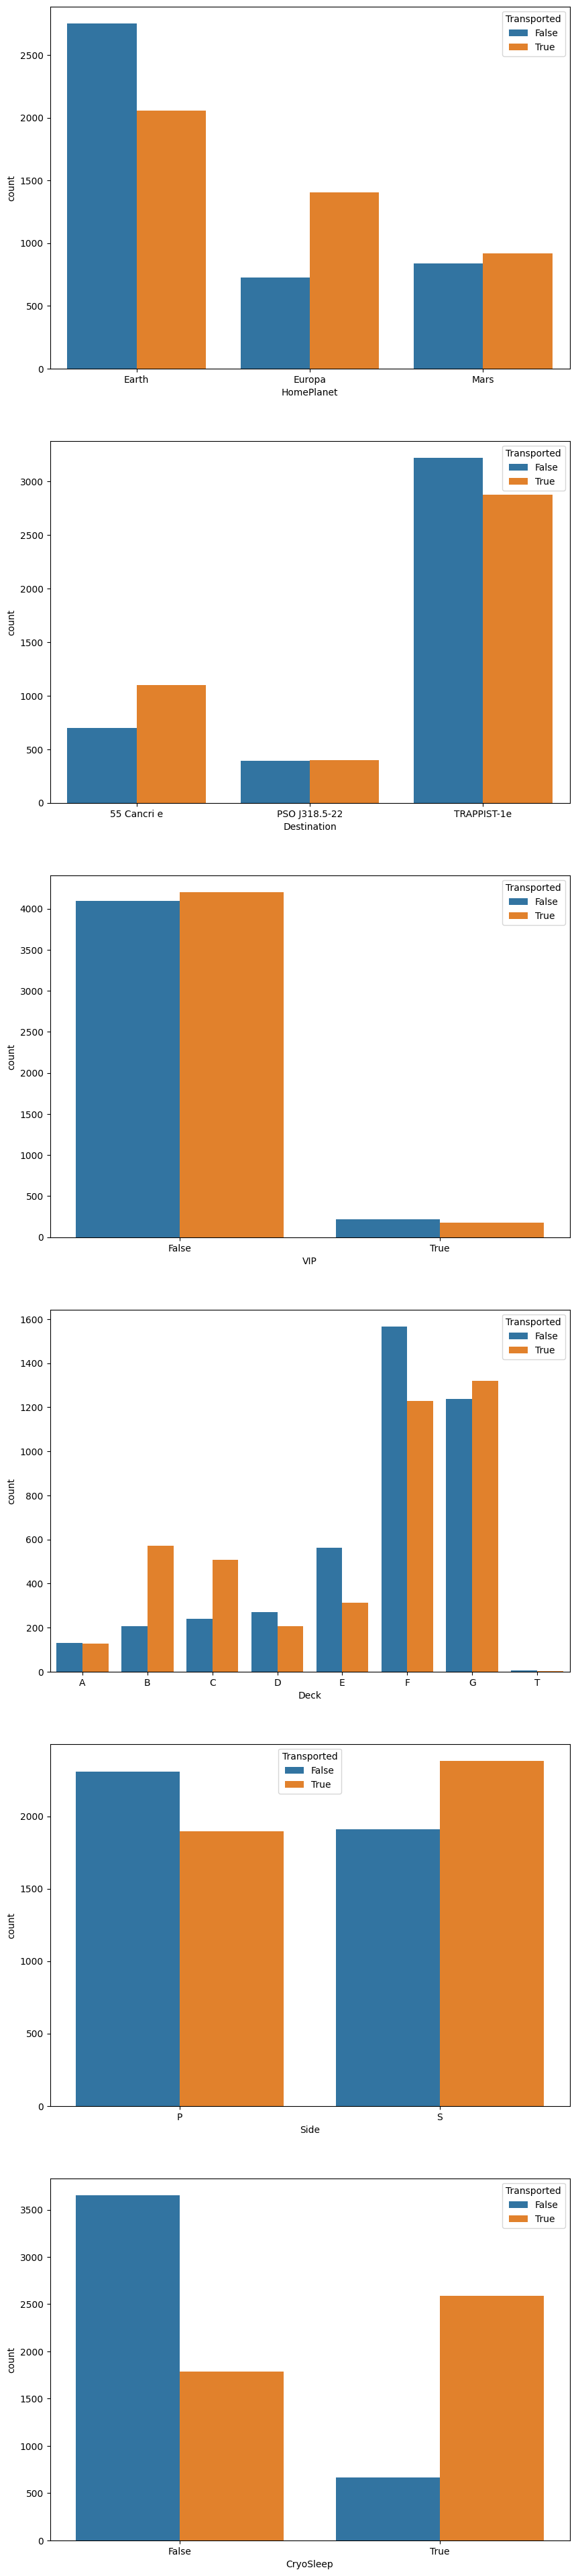

In [17]:
fig, ax = plt.subplots(6, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

sns.countplot(x='HomePlanet', hue='Transported', data=train_data, ax=ax[0])
sns.countplot(x='Destination', hue='Transported', data=train_data, ax=ax[1])
sns.countplot(x='VIP', hue='Transported', data=train_data, ax=ax[2])
sns.countplot(x='Deck', hue='Transported', data=train_data, ax=ax[3])
sns.countplot(x='Side', hue='Transported', data=train_data, ax=ax[4])
sns.countplot(x='CryoSleep', hue='Transported', data=train_data, ax=ax[5])

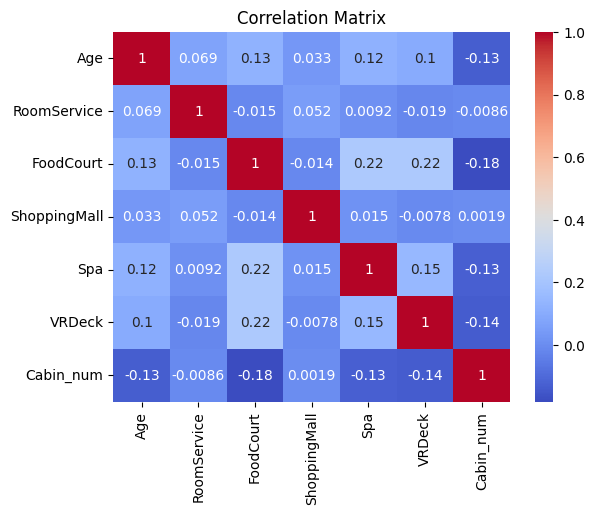

In [75]:
numerical_columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin_num"]
numerical_corr = train_data[numerical_columns].corr()
ax =plt.axes()
sns.heatmap(numerical_corr, cmap="coolwarm", annot=True, ax=ax)
ax.set_title("Correlation Matrix")
plt.show()

One Hot Encoding

In [19]:


train_data_before_encoding = train_data.copy()

encoder = OneHotEncoder(drop="first")
train_data_encoded = encoder.fit_transform(
    train_data[["HomePlanet", "Destination", "VIP", "Deck", "Side"]]
)


train_data_encoded = pd.DataFrame(
    train_data_encoded.toarray(),
    columns=encoder.get_feature_names_out(
        ["HomePlanet", "Destination", "VIP", "Deck", "Side"]
    ),
)

train_data.drop(
    ["HomePlanet", "Destination", "VIP", "Deck", "Side"], axis=1, inplace=True
)

train_data = pd.concat([train_data, train_data_encoded], axis=1)

Walidacja krzyżowa

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
def split_data(data):
    X = data.drop(columns=["Transported"])
    y = data["Transported"]
    return X, y

In [22]:
X, y = split_data(train_data)
X_before_missing, y_before_missing = split_data(train_data_before_missing)
X_before_encoding, y_before_encoding = split_data(train_data_before_encoding)

In [23]:
display(X_before_missing)
display(X_before_encoding)
display(X)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98.0,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499.0,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500.0,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608.0,S


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,VIP_is_null,RoomService_is_null,FoodCourt_is_null,ShoppingMall_is_null,Spa_is_null,VRDeck_is_null,Transported_is_null,Deck_is_null,Cabin_num_is_null,Side_is_null
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0,0,0,0,0,0,0,0,0,0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,0,0,0,0,0,0,0,0,0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,0,0,0,0,0,0,0,0,0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,...,0,0,0,0,0,0,0,0,0,0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,...,0,0,0,0,0,0,0,0,0,0


,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,HomePlanet_is_null,CryoSleep_is_null,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_nan,Side_S,Side_nan
0,False,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,24.0,109.0,9.0,25.0,549.0,44.0,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,False,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,False,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,False,16.0,303.0,70.0,151.0,565.0,2.0,1.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,True,18.0,0.0,0.0,0.0,0.0,0.0,1499.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8690,False,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8691,False,32.0,0.0,1049.0,0.0,353.0,3235.0,608.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Uruchomienie algorytmów Random Forest [1], Histogram-based Gradient Boosting [2], XGBoost [3], LightGBM[4], CatBoost[5] bez szukania hiperparametrów, ale z walidacją krzyżową. Porównanie rezultatów.

In [24]:
def show_results(results):
    print(f"Mean test score: {results["test_f1"].mean():.4f} +/- {results["test_f1"].std():.4f}")
    print(f"Mean train score: {results["train_f1"].mean():.4f} +/- {results["train_f1"].std():.4f}")
    print(f"Mean fit time: {results["fit_time"].mean():.4f} +/- {results["fit_time"].std():.4f} seconds")
    print(f"Mean score time: {results["score_time"].mean():.4f} +/- {results["score_time"].std():.4f} seconds")

## Random Forest
- Ogólnie zbiór drzew decyzyjnych. 
- Wprowadzona losować przeciwdziała nadmiernemu dopasowaniu.
- Każde drzewo jest trenowane na innym podzbiorze danych. (nieskorealowane jest ważne) bootstraping
- Klasyfikacja odbywa się przez głosowanie większościowe.

In [25]:


rfc = RandomForestClassifier(random_state=42)


scoring = ["f1"]
rfc_results = cross_validate(
    rfc,
    X,
    y,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(rfc_results)

Mean test score: 0.7938 +/- 0.0122
Mean train score: 0.9996 +/- 0.0001
Mean fit time: 1.6794 +/- 0.3286 seconds
Mean score time: 0.0517 +/- 0.0096 seconds


- Random Forest nie przyjmuje brakujących danych, więc trzeba je uzupełnić. 
- Random Forest nie przyjmuje danych kategorialnych, więc trzeba je zakodować.

## Histogram-based Gradient Boosting

- głosowanie większościowe
- Wprowadza wczesne zatrzymywanie (early stopping) - zatrzymuje trenowanie, gdy nie ma poprawy - przeciwdziała niepotrzebnemu tworzeniu drzew. A do tego używa zbioru walidacyjnego.
- buduje drzewa sekwencyjnie, gdzie każde kolejne drzewo próbuje skorygować błędy popełnione przez poprzednie. HGBT używa histogramów cech (tj. dyskretyzuje ciągłe cechy do skończonej liczby przedziałów)

In [26]:


categorical_columns = ["HomePlanet", "Destination", "Deck", "Side"]

hgbc = HistGradientBoostingClassifier(
    random_state=42, categorical_features=categorical_columns
)
# perform cross validation
scoring = ["f1"]
hgbc_results = cross_validate(
    hgbc,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(hgbc_results)

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Mean test score: 0.8125 +/- 0.0072
Mean train score: 0.8976 +/- 0.0019
Mean fit time: 1.7949 +/- 0.3040 seconds
Mean score time: 0.0472 +/- 0.0065 seconds


- Histogram-based Gradient Boosting przyjmuje brakujące dane, więc nie trzeba ich uzupełniać.
- Histogram-based Gradient Boosting przyjmuje dane kategorialne, więc nie trzeba ich kodować. - wystarczy przekazać kolumny kategorialne w parametrze `categorical_features`.

## XGBoost

- ekstremanlnie szybki algorytm ;)
- wbudowana regularyzacja L1 i L2 - przeciwdziała nadmiernemu dopasowaniu
- wysoka wydajność, skalowalność i dokładność
- Dobrze radzi sobie z niezbalansowanymi klasami

In [27]:


xgb = XGBClassifier(
    random_state=42,
    enable_categorical=True,
)

xgb_results = cross_validate(
    xgb,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(xgb_results)

Mean test score: 0.8023 +/- 0.0104
Mean train score: 0.9409 +/- 0.0034
Mean fit time: 0.5275 +/- 0.0405 seconds
Mean score time: 0.0359 +/- 0.0042 seconds


- XGBoost przyjmue dane katoryczne, nie trzeba ich kodować
- XGBoost przyjmuje brakujące dane

## LightGBM

- Wersja "light" XGBoost - mmniejsze zużycie pamięci, 
- szybsze trenowanie
- idealny do "dużych" zbiorów danych
- np. Techniki Gradient-Based One-Side Sampling (GOSS) - handle large datasets 
- np. techniki DART (Dropouts meet Multiple Additive Regression Trees)
- Leaf-wise Tree Growth - Działa poprzez powiększenie węzła liścia z największym przyrostem podziału spośród wszystkich liści drzewa. Najlepsza funkcja i próg, które optymalizują funkcję celu, dzielą węzeł główny na dwa węzły podrzędne. Procedura jest następnie powtarzana do momentu osiągnięcia warunku zatrzymania (takiego jak maksymalna głębokość, maksymalna liczba liści lub minimalna poprawa) poprzez wybranie jednego z węzłów podrzędnych jako następnego liścia do podziału. Nawet przy użyciu planu rozwoju drzewa według liści, drzewo może nie być zrównoważone lub mieć liście o podobnej głębokości


In [28]:


lgbm = lgb.LGBMClassifier(random_state=42)


lgbm_results = cross_validate(
    lgbm,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(lgbm_results)

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

- LightGBM przyjmuje dane katoryczne, nie trzeba ich kodować
- LightGBM przyjmuje brakujące dane

## CatBoost (Categorical Boosting)

- brak potrzeby kodowania danych kategorycznych - CatBoost sam to robi (one hot prowadzi do sparse matrix - które prowadzą do przeuczenia)
- brakujące dane - symmetric weighted quantile sketch(SWQS)  (technika dzielenia)
- automatyzczne skalowanie
- Bardzo dobre wyniki
- Długi treninig...
- odporność na przeuczenie


In [29]:


X_before_missing["HomePlanet"] = X_before_missing["HomePlanet"].astype(str)
X_before_missing["Destination"] = X_before_missing["Destination"].astype(str)
X_before_missing["Deck"] = X_before_missing["Deck"].astype(str)
X_before_missing["Side"] = X_before_missing["Side"].astype(str)

cat = CatBoostClassifier(random_state=42, verbose=0, cat_features=categorical_columns)

cat_results = cross_validate(
    cat,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(cat_results)

Mean test score: 0.8162 +/- 0.0064
Mean train score: 0.8652 +/- 0.0032
Mean fit time: 50.6410 +/- 11.7851 seconds
Mean score time: 0.0279 +/- 0.0111 seconds


## Porównanie

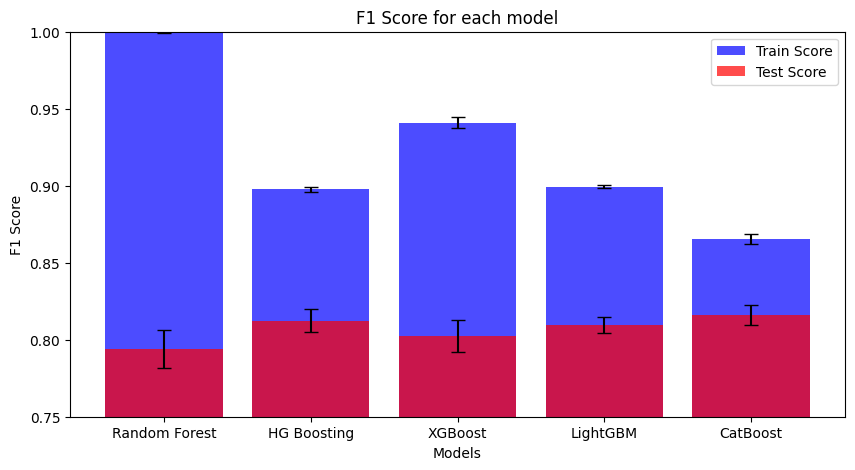

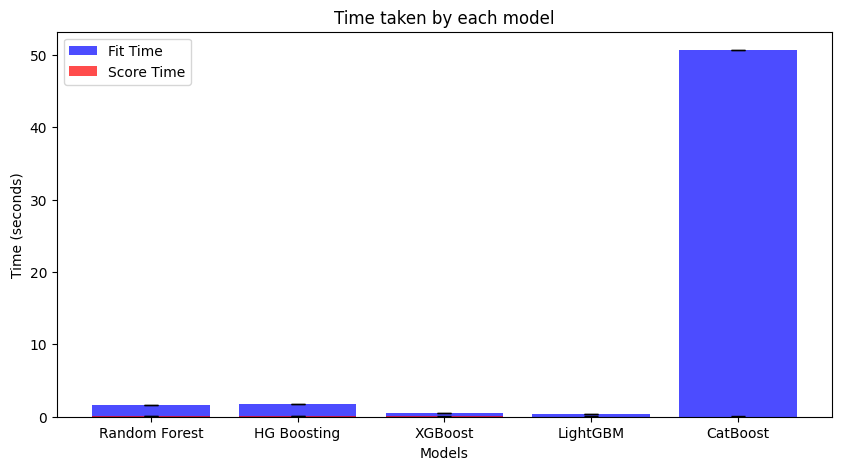

In [30]:
models = ["Random Forest", "HG Boosting", "XGBoost", "LightGBM", "CatBoost"]

mean_train_scores = [
    rfc_results["train_f1"].mean(),
    hgbc_results["train_f1"].mean(),
    xgb_results["train_f1"].mean(),
    lgbm_results["train_f1"].mean(),
    cat_results["train_f1"].mean(),
]

std_train_scores = [
    rfc_results["train_f1"].std(),
    hgbc_results["train_f1"].std(),
    xgb_results["train_f1"].std(),
    lgbm_results["train_f1"].std(),
    cat_results["train_f1"].std(),
]

mean_scores = [
    rfc_results["test_f1"].mean(),
    hgbc_results["test_f1"].mean(),
    xgb_results["test_f1"].mean(),
    lgbm_results["test_f1"].mean(),
    cat_results["test_f1"].mean(),
]

std_scores = [
    rfc_results["test_f1"].std(),
    hgbc_results["test_f1"].std(),
    xgb_results["test_f1"].std(),
    lgbm_results["test_f1"].std(),
    cat_results["test_f1"].std(),
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(models, mean_train_scores, yerr=std_train_scores, capsize=5, color="b", alpha=0.7, label="Train Score")
ax.bar(models, mean_scores, yerr=std_scores, capsize=5, color="r", alpha=0.7, label="Test Score")
ax.set_xlabel("Models")
ax.set_ylabel("F1 Score")
plt.ylim(0.75, 1.0)
ax.set_title("F1 Score for each model")
plt.legend()
plt.show()

models = ["Random Forest", "HG Boosting", "XGBoost", "LightGBM", "CatBoost"]

mean_fit_time = [
    rfc_results["fit_time"].mean(),
    hgbc_results["fit_time"].mean(),
    xgb_results["fit_time"].mean(),
    lgbm_results["fit_time"].mean(),
    cat_results["fit_time"].mean(),
]

mean_score_time = [
    rfc_results["score_time"].mean(),
    hgbc_results["score_time"].mean(),
    xgb_results["score_time"].mean(),
    lgbm_results["score_time"].mean(),
    cat_results["score_time"].mean(),
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(models, mean_fit_time, color="b", alpha=0.7, label="Fit Time", yerr=std_train_scores, capsize=5,)
ax.bar(models, mean_score_time, color="r", alpha=0.7, label="Score Time", yerr=std_scores, capsize=5,)
ax.set_xlabel("Models")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time taken by each model")
plt.legend()
plt.show()


# Szukanie hiperparametrów za pomocą Optuny dla CatBoost'a
## jak działa Optuna?
- optuna jest biblioteką do automatycznego strojenia hiperparametrów
- używa algorytmów optymalizacji bayesowskiej

In [31]:
warnings.filterwarnings("ignore")

c:\Users\filip\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## jakie parametry będziemy stroić?:
- `learning_rate` - Określa "szybkość uczenia się" modelu. Niskie wartości wymagają większej liczby drzew (n_estimators) do trenowania modelu
- `n_estimators` - Liczba drzew do zbudowania w ramach modelu. Większa liczba drzew może poprawić dokładność
- `objective` - Funkcja celu, którą model stara się zoptymalizować.
- `colsample_bylevel` - jaki procent kolumn wybieramy na każdym poziomie drzewa do budowania węzłów. 
- `depth` - Maksymalna głębokość drzew. Głębsze drzewa mogą lepiej dopasować się do danych, ale również zwiększają ryzyko przeuczenia.
- `boosting_type` - typ boosting'u. Typ metody boosting. "Ordered" zapewnia lepszą dokładność na koszt większego czasu trenowania, podczas gdy "Plain" jest szybszy, ale może być mniej dokładny.
- `bootstrap_type` - typ bootstrap'u. Metoda próbkowania używana do trenowania drzew. "Bayesian" i "Bernoulli" pozwalają na losowe próbkowanie danych z pewnymi strategiami, podczas gdy "MVS" jest metodą próbkowania opartą na minimalnej wariancji.
- `bagging_temperature` - temperatura bagging'u. (dla "Bayesian"): Reguluje stopień losowości w próbkowaniu, gdzie wyższe wartości prowadzą do większej losowości.
- `subsample` - (dla "Bernoulli") jaki procent danych używamy do trenowania, co może pomóc w zapobieganiu przeuczeniu.

In [34]:
def objective(trial: optuna.Trial) -> float:

    param = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "objective": trial.suggest_categorical(
            "objective", ["Logloss", "CrossEntropy"]
        ),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.01, 0.1, log=True
        ),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "F1",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    fi_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, valid_index in skf.split(X_before_missing, y_before_missing):
        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

        gbm = cb.CatBoostClassifier(**param)

        # pruning_callback = CatBoostPruningCallback(trial, "F1")

        gbm.fit(
            train_x,
            train_y,
            verbose=0,
            # callbacks=[pruning_callback],
        )

        # pruning_callback.check_pruned()

        preds = gbm.predict(valid_x)
        f1 = f1_score(valid_y, preds)

        fi_scores.append(f1)

    return np.mean(fi_scores)

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-12 11:10:04,919] A new study created in memory with name: no-name-0831b983-3f51-4e4b-bf5c-f5a1a9551e24
[I 2024-06-12 11:10:54,711] Trial 0 finished with value: 0.7276248308437891 and parameters: {'learning_rate': 0.002076353848732037, 'n_estimators': 803, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.02453297656303739, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.5363233442780073}. Best is trial 0 with value: 0.7276248308437891.
[I 2024-06-12 11:11:18,526] Trial 1 finished with value: 0.7977268163153175 and parameters: {'learning_rate': 0.4379099216302617, 'n_estimators': 423, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.011471000579654429, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.73281895258239}. Best is trial 1 with value: 0.7977268163153175.
[I 2024-06-12 11:11:41,179] Trial 2 finished with value: 0.8056386389291366 and parameters: {'learning_rate': 0.41724

Number of finished trials: 100
Best trial:
  Value: 0.8176445505770381
  Params: 
    learning_rate: 0.026604871347659466
    n_estimators: 1000
    objective: CrossEntropy
    colsample_bylevel: 0.08823808134018762
    depth: 11
    boosting_type: Ordered
    bootstrap_type: MVS


In [52]:


with open("best_cat_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f)

In [36]:
optuna.visualization.plot_optimization_history(study)

In [38]:
optuna.visualization.plot_slice(study, params=["learning_rate", "n_estimators", "colsample_bylevel", "depth"])

In [39]:
optuna.visualization.plot_param_importances(study)

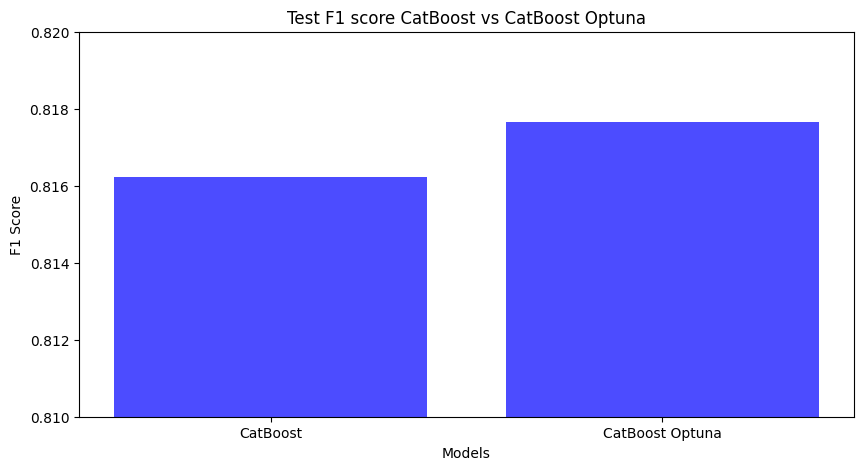

In [62]:
cat_f1 = cat_results["test_f1"].mean()
cat_optuna_f1 = trial.value

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(["CatBoost", "CatBoost Optuna"], [cat_f1, cat_optuna_f1], color="b", alpha=0.7)
ax.set_xlabel("Models")
ax.set_ylabel("F1 Score")
ax.set_title("Test F1 score CatBoost vs CatBoost Optuna")
ax.set_ylim(0.81, 0.82)
plt.show()


#  Wybranie jednego z powyższych algorytmów wspierających jedną z następujących funkcjonalności: ograniczenia monotoniczności, ograniczenia interackji, własne funkcje straty lub inne wybrane. Przeprowadzenie eksperymentu sprawdzającego wpływ (jednej) wybranej funkcjonalności na wyniki oraz zachowanie modelu.

In [46]:
X_before_missing

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98.0,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499.0,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500.0,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608.0,S


## Ograniczenia monotoniczności

In [68]:
categorical_columns = ["HomePlanet", "Destination", "Deck", "Side"]
for col in categorical_columns:
    X_before_missing[col] = X_before_missing[col].astype("category")

monotone_constraints = (0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0)

xgb_model_no_constraints = XGBClassifier(
    random_state=42,
    enable_categorical=True,
)
xgb_model_with_constraints = XGBClassifier(
    random_state=42, enable_categorical=True, monotone_constraints=monotone_constraints
)

xgb_model_no_constraints_results = cross_validate(
    xgb_model_no_constraints,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(xgb_model_no_constraints_results)

xgb_model_with_constraints_results = cross_validate(
    xgb_model_with_constraints,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)


show_results(xgb_model_with_constraints_results)


models = ["XGBoost", "XGBoost with Constraints"]

mean_train_scores = [
    xgb_model_no_constraints_results["train_f1"].mean(),
    xgb_model_with_constraints_results["train_f1"].mean(),
]

std_train_scores = [
    xgb_model_no_constraints_results["train_f1"].std(),
    xgb_model_with_constraints_results["train_f1"].std(),
]

mean_scores = [
    xgb_model_no_constraints_results["test_f1"].mean(),
    xgb_model_with_constraints_results["test_f1"].mean(),
]

std_scores = [
    xgb_model_no_constraints_results["test_f1"].std(),
    xgb_model_with_constraints_results["test_f1"].std(),
]


Mean test score: 0.7976 +/- 0.0083
Mean train score: 0.9388 +/- 0.0031
Mean fit time: 0.4703 +/- 0.0870 seconds
Mean score time: 0.0328 +/- 0.0083 seconds
Mean test score: 0.7290 +/- 0.0091
Mean train score: 0.7926 +/- 0.0032
Mean fit time: 2.9640 +/- 0.2455 seconds
Mean score time: 0.0405 +/- 0.0071 seconds


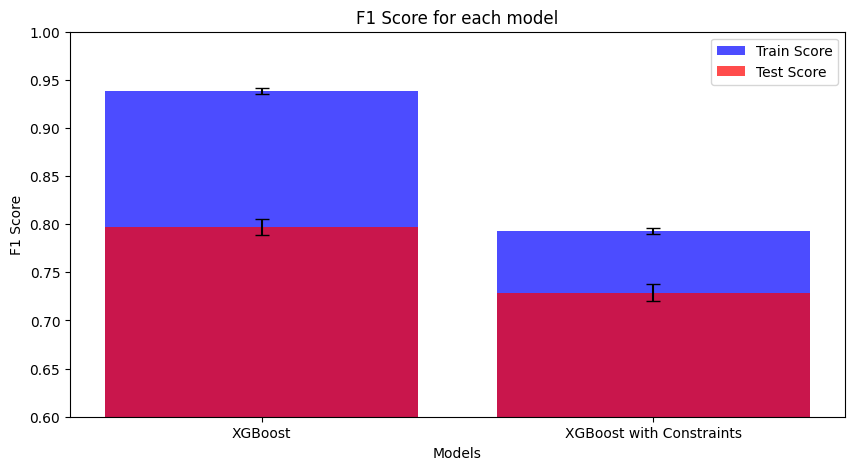

In [69]:

fig, ax = plt.subplots(figsize=(10, 5)) 
ax.bar(models, mean_train_scores, yerr=std_train_scores, capsize=5, color="b", alpha=0.7, label="Train Score")
ax.bar(models, mean_scores, yerr=std_scores, capsize=5, color="r", alpha=0.7, label="Test Score")
ax.set_xlabel("Models")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score for each model")
ax.set_ylim(0.60, 1.0)
plt.legend()
plt.show()

## Badanie przypisania funkcji kosztu

Dobra funkcja straty opiera się na funkcji straty logistycznej. Gradient i hesjan są wyprowadzone z funkcji straty logistycznej

$$
L(y_{\text{true}}, y_{\text{pred}}) = -\left(y_{\text{true}} \log(p) + (1 - y_{\text{true}}) \log(1 - p)\right)
$$

$$
 p = \frac{1}{1 + \exp(-y_{\text{pred}})}
$$

$$
\text{gradient} = p - y_{\text{true}}
$$

$$
\text{hessian} = p \cdot (1 - p)
$$

Suboptymalna funkcja straty jest prostą funkcją błędu kwadratowego. Gradient i hesjan są wyprowadzone z funkcji błędu kwadratowego

$$
L(y_{\text{true}}, y_{\text{pred}}) = (y_{\text{pred}} - y_{\text{true}})^2
$$

$$
\text{gradient} = 2 \cdot (y_{\text{pred}} - y_{\text{true}})
$$

$$
\text{hessian} = 2

$$

Mean test score: 0.7976 +/- 0.0083
Mean train score: 0.9388 +/- 0.0031
Mean fit time: 0.4703 +/- 0.0870 seconds
Mean score time: 0.0328 +/- 0.0083 seconds

Mean test score: 0.8017 +/- 0.0044
Mean train score: 0.9422 +/- 0.0022
Mean fit time: 0.6738 +/- 0.0647 seconds
Mean score time: 0.0378 +/- 0.0031 seconds

Mean test score: 0.7010 +/- 0.0036
Mean train score: 0.7202 +/- 0.0003
Mean fit time: 0.7240 +/- 0.0652 seconds
Mean score time: 0.0355 +/- 0.0020 seconds



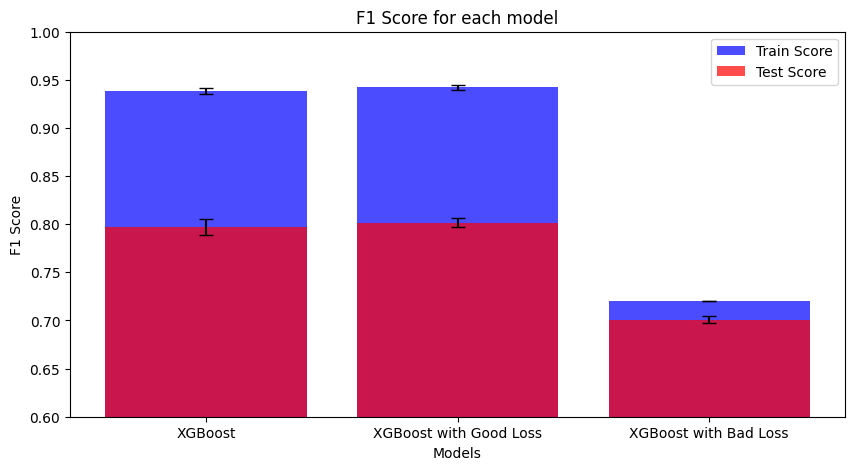

In [71]:


show_results(xgb_model_no_constraints_results)
print()

def custom_loss_function_good(y_true, y_pred):
    p = 1.0 / (1.0 + np.exp(-y_pred))
    gradient = p - y_true
    hessian = p * (1 - p)
    return gradient, hessian


def custom_loss_function_bad(y_true, y_pred):
    gradient = 2 * (y_pred - y_true)
    hessian = 2 * np.ones_like(y_true)
    return gradient, hessian


xgb_model_with_custom_loss_good = XGBClassifier(
    random_state=42, enable_categorical=True, objective=custom_loss_function_good
)

xgb_model_with_custom_loss_bad = XGBClassifier(
    random_state=42, enable_categorical=True, objective=custom_loss_function_bad
)

xgb_model_with_custom_loss_good_results = cross_validate(
    xgb_model_with_custom_loss_good,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(xgb_model_with_custom_loss_good_results)
print()
xgb_model_with_custom_loss_bad_results = cross_validate(
    xgb_model_with_custom_loss_bad,
    X_before_missing,
    y_before_missing,
    scoring=scoring,
    cv=skf,
    return_train_score=True,
)

show_results(xgb_model_with_custom_loss_bad_results)
print()

models = ["XGBoost", "XGBoost with Good Loss", "XGBoost with Bad Loss"]

mean_train_scores = [
    xgb_model_no_constraints_results["train_f1"].mean(),
    xgb_model_with_custom_loss_good_results["train_f1"].mean(),
    xgb_model_with_custom_loss_bad_results["train_f1"].mean(),
]

std_train_scores = [
    xgb_model_no_constraints_results["train_f1"].std(),
    xgb_model_with_custom_loss_good_results["train_f1"].std(),
    xgb_model_with_custom_loss_bad_results["train_f1"].std(),
]

mean_scores = [
    xgb_model_no_constraints_results["test_f1"].mean(),
    xgb_model_with_custom_loss_good_results["test_f1"].mean(),
    xgb_model_with_custom_loss_bad_results["test_f1"].mean(),
]

std_scores = [
    xgb_model_no_constraints_results["test_f1"].std(),
    xgb_model_with_custom_loss_good_results["test_f1"].std(),
    xgb_model_with_custom_loss_bad_results["test_f1"].std(),
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(models, mean_train_scores, yerr=std_train_scores, capsize=5, color="b", alpha=0.7, label="Train Score")
ax.bar(models, mean_scores, yerr=std_scores, capsize=5, color="r", alpha=0.7, label="Test Score")
ax.set_xlabel("Models")
ax.set_ylabel("F1 Score")
plt.ylim(0.6, 1.0)
ax.set_title("F1 Score for each model")
plt.legend()
plt.show()

# Bonus: załadowanie parametru najelpszego modelu z poprzedniego zadania i przeprowadzenie ewaulacji na zbiorze testowym. + wysłasnie submission na kaggle

In [ ]:

test_data = pd.read_csv("./spaceship-titanic/test.csv")
test_data = test_data.drop(["PassengerId", "Name"], axis=1)

test_data[["Deck", "Cabin_num", "Side"]] = test_data["Cabin"].str.split("/", expand=True)
test_data["Cabin_num"] = pd.to_numeric(test_data["Cabin_num"], errors="coerce")

try:
    test_data = test_data.drop("Cabin", axis=1)
except KeyError:
    print("Field does not exist")

test_data["CryoSleep"] = test_data["CryoSleep"].astype(bool)
test_data["VIP"] = test_data["VIP"].astype(bool)

categorical_columns = ["HomePlanet", "Destination", "Deck", "Side"]
for col in categorical_columns:
    test_data[col] = test_data[col].astype("str")


display(test_data.head())

In [ ]:
best_params = trial.params
best_model = cb.CatBoostClassifier(**best_params, cat_features=categorical_columns)

best_model.fit(X_before_missing, y_before_missing, verbose=0)

predictions = best_model.predict(test_data)


In [ ]:
sample_submission = pd.read_csv("./spaceship-titanic/sample_submission.csv")
sample_submission["Transported"] = predictions

sample_submission.to_csv("submission_cat.csv", index=False)

display(sample_submission.head())

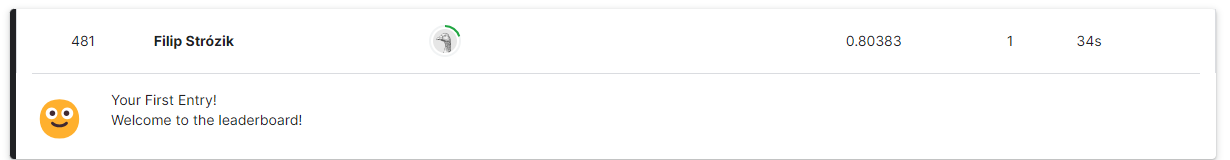

In [ ]:
hgbc = HistGradientBoostingClassifier(
    random_state=42, categorical_features=categorical_columns
)

hgbc.fit(X_before_missing, y_before_missing)

predictions = hgbc.predict(test_data)

sample_submission["Transported"] = predictions

sample_submission.to_csv("submission_hgbc.csv", index=False)

display(sample_submission.head())

https://www.kaggle.com/competitions/spaceship-titanic/leaderboard